# Gridded monthly fog fraction

## Introduction

The process used in the Hawai\`i Water Budget (HWB) code to include fog interception in the water balance was a bit too complex to translate for use with SWB; because of the way SWB interacts with grids and tables, an excessive amount of computation was required to process the existing fog fraction tables and shapefiles. A new process was developed that captures the essence of the HWB procedure without requiring the excess computational burden. This process involves a grid computation using the aspect, elevation, and mean monthly rainfall combined with table values of estimated annual fog interception rates to yield monthly fog interception grids expressed as a fraction of monthly rainfall amounts. 

![](images\Fog_Fraction_Grid_Creation.PNG)

The script below was used to create the fog fraction grids for the Maui test case.

```
import arcpy
from arcpy import env
from arcpy.sa import *

arcpy.CheckOutExtension("Spatial")

env.workspace = "GIS"
rainfall_path = "Rainfall_Atlas/Maui"
project_GIS_path="GIS"

# DEM is a 10-m resolution DEM obtained from
# http://gis.ess.washington.edu/data/raster/tenmeter/hawaii/
# specifically: http://gis.ess.washington.edu/data/raster/tenmeter/hawaii/maui.zip
DEM_grid = project_GIS_path + "/maui_elev_ft"

# windward/leeward classification obtained from "ASPECT" field within the polygon shapefile
# Filename = maui_wb_polygon_attributes.shp
# Reclassified this shapefile such that WINDWARD=1; LEEWARD=0
windward_grid = project_GIS_path + "/maui_windward"

arcpy.env.cellSize = 15.
# set the extent so that there is a comfortable buffer of NODATA cells surrounding island
arcpy.env.extent = arcpy.Extent(739500., 2276800., 819000., 2332000.)

windward = Raster(windward_grid)
DEM = Raster(DEM_grid)

# These values come from the values given to me by *** in an email of 9/11/2014:
#
# Alt, ft above msl      Fog interception rate (in/year)
#  FROM     TO        LEEWARD     WINDWARD
#     0  <2000              0            0
#  2000   8200             14           30
# >8200  <9000             10           18
#    >9000                  6            6
#

temp1 = Con( ( DEM > 2000.0 ) & ( DEM < 8200.0 ) , Con( windward==1, 30.0, 14.0 ), 0.0)
temp1 = Con( ( DEM > 8200.0 ) & ( DEM < 9000.0 ) , Con( windward==1, 18.0, 10.0 ), temp1 )
fog_interception = Con( ( DEM > 9000.0 ), 6.0, temp1 ) / 12.0

# ASSUME that the ANNUAL value can be uniformly distributed over the months of the year: divide by 12

for month in range(1,13):
    raingrid = rainfall_path + "/" + "rf_in_ma_" + ("%02d" % month )

    fog_fraction_grid = project_GIS_path + "/" + "maui_fog_ratio_monthly_" + ("%02d" % month ) + ".asc"

    print "Now processing " + raingrid

    rainvals = Raster( raingrid )

    # NOW, to come up with a monthly fog-to-rainfall fraction, divide by each monthly rainfall amount
    # Mean monthly rainfall from Giambelluca's group, 2014
    #  ( http://rainfall.geography.hawaii.edu/assets/files/GISLayers/MauiASCIIGrids_inches.zip )
    fog_fraction = fog_interception / rainvals

    print "  rainfall     --   min: " + str( rainvals.minimum ) + "   max: " + str( rainvals.maximum )
    print "  fog fraction --   min: " + str( fog_fraction.minimum ) + "   max: " + str( fog_fraction.maximum )

    arcpy.RasterToASCII_conversion( fog_fraction, fog_fraction_grid )
```


## Preliminaries


In [1]:
import os
import numpy as np
import pandas as pd
import gdal

%run ../../COMMON/plot_and_table_functions.py

# grid files
example_fog_grid_filename  = '../input/fog_fraction_grids/maui_fog_ratio_monthly_01__50m..asc'

## Read grid

In [2]:
# read in runoff zone grid
fog_data, fog_gt, fog_proj, fog_xy  = read_raster( example_fog_grid_filename )


reading in ../input/fog_fraction_grids/maui_fog_ratio_monthly_01__50m..asc into numpy array...
creating a grid of xy coordinates in the original projection...


## Input grid

### Example Fog Fraction Grid

An example of one of the fog fraction grids supplied to SWB is shown below.

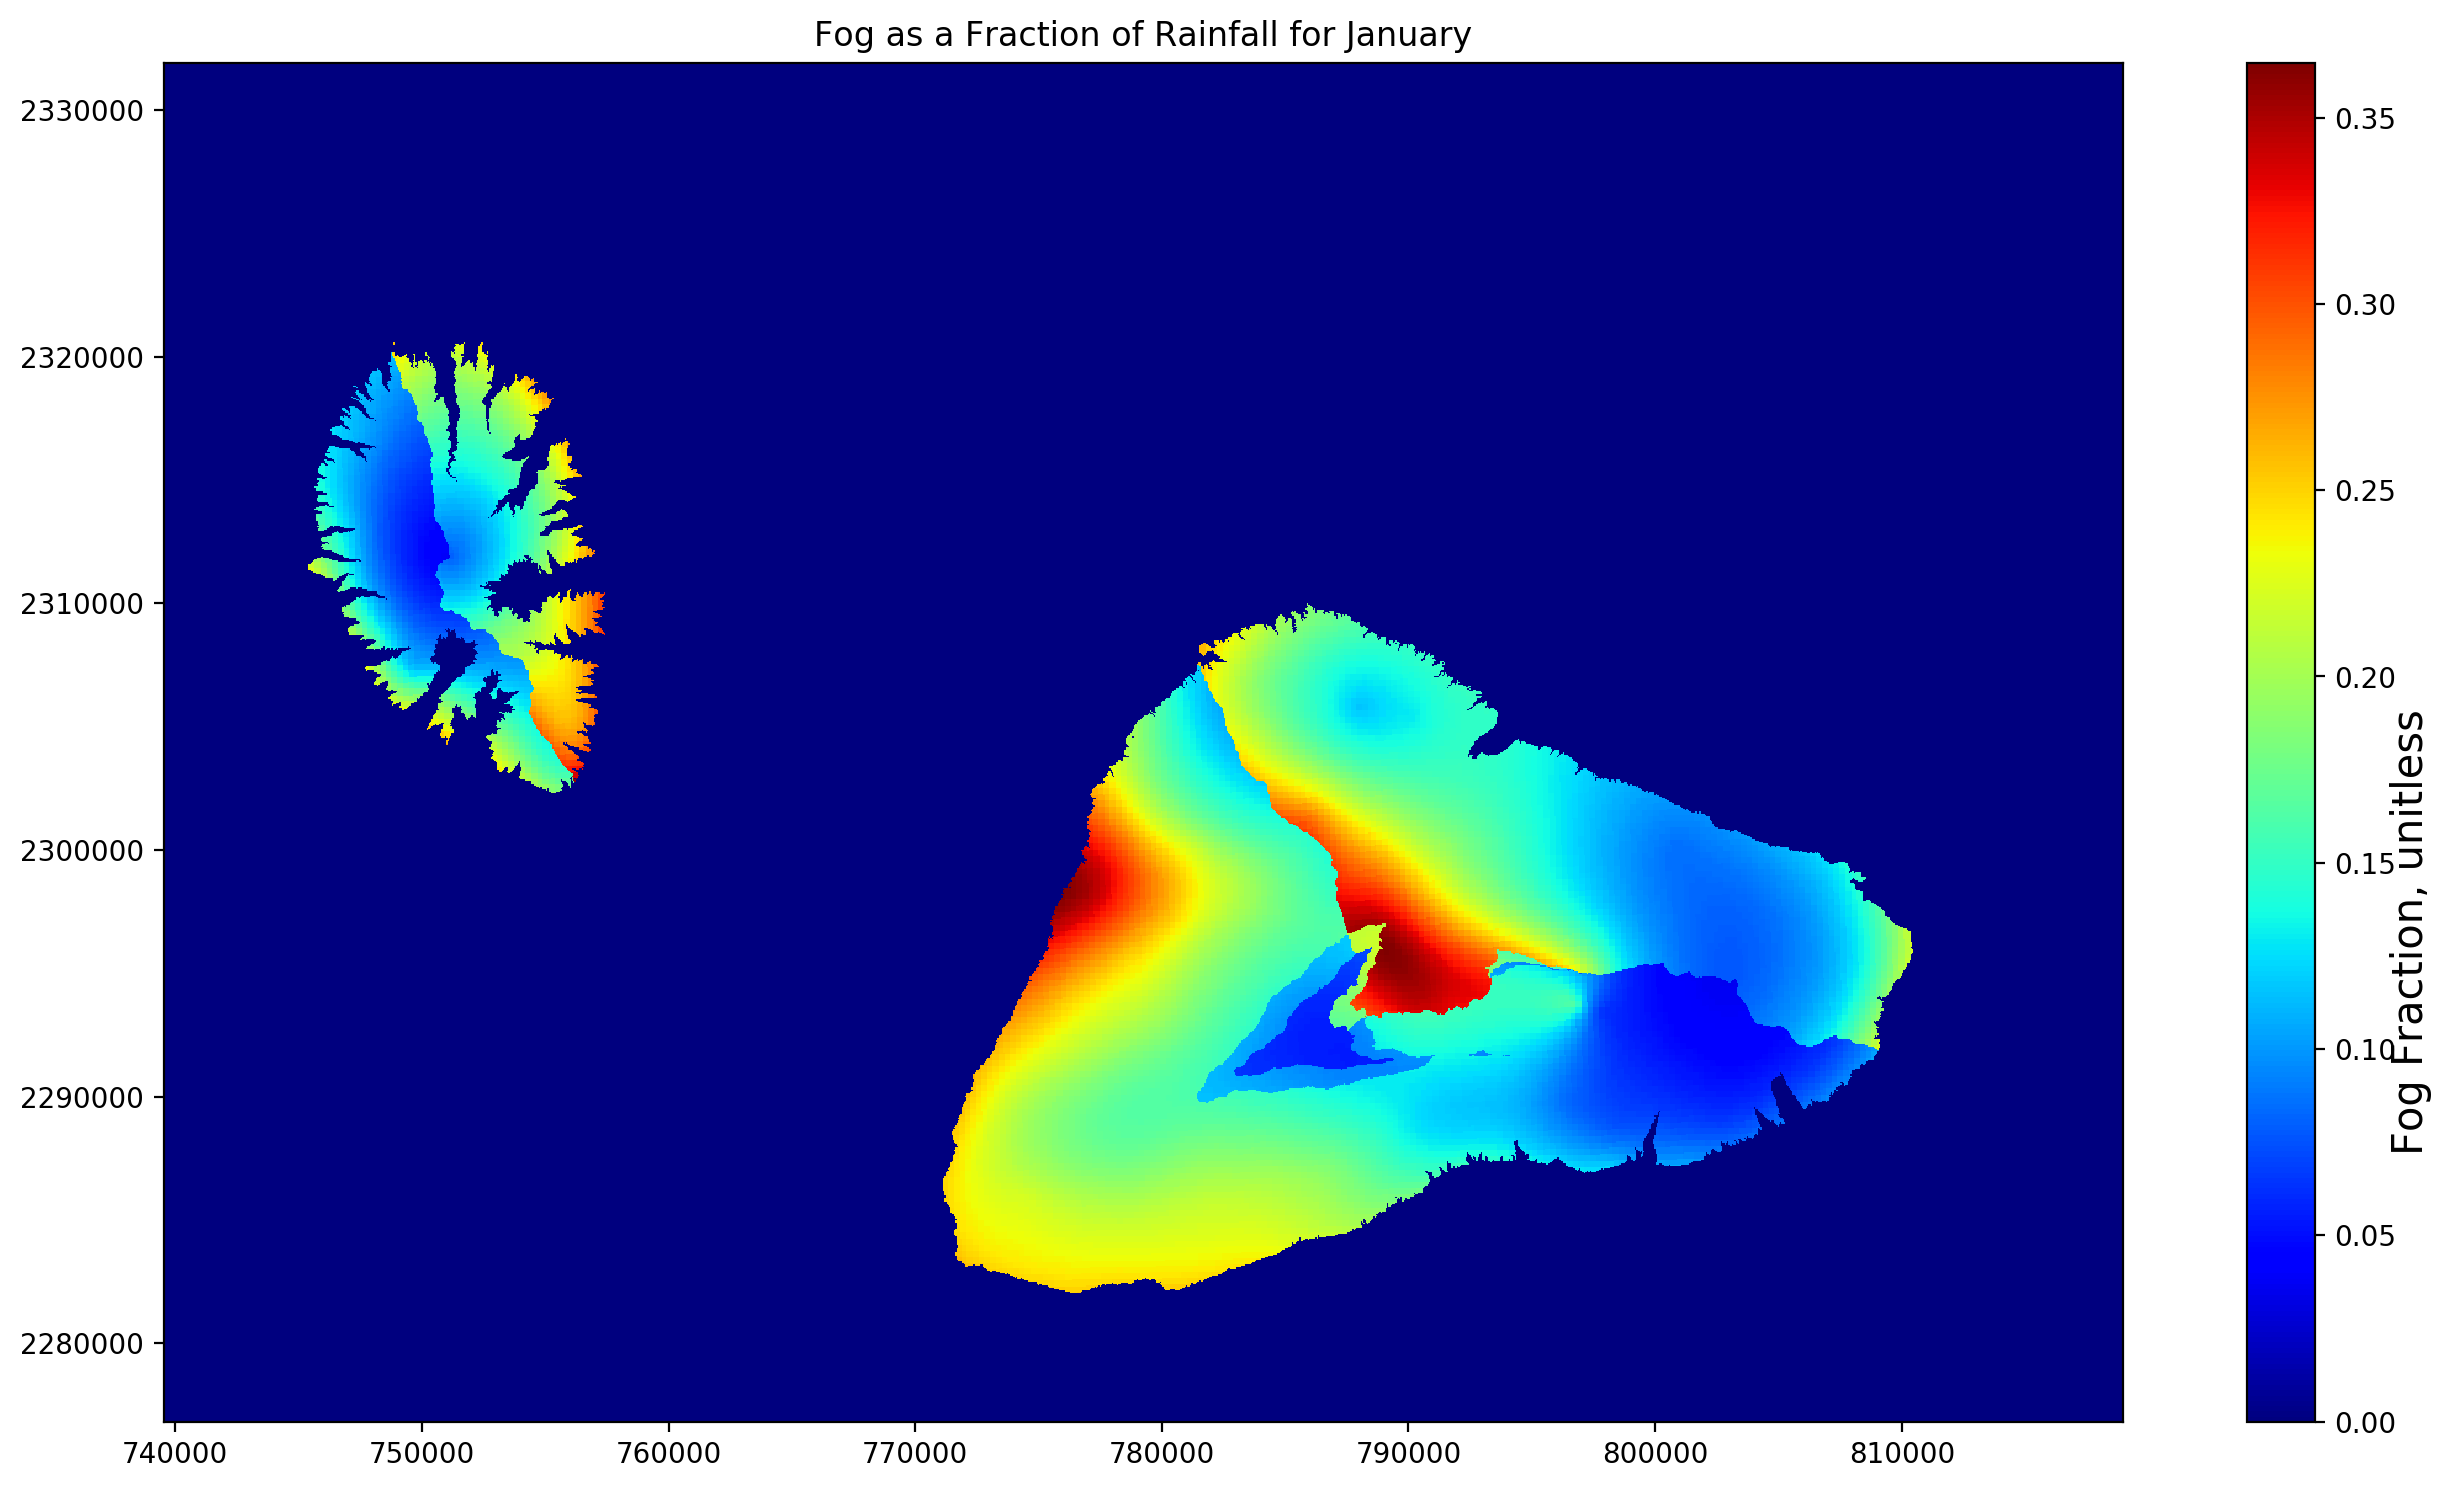

In [3]:
make_plot( x=fog_xy[0], y=fog_xy[1], var=fog_data, discrete=False,
           title='Fog as a Fraction of Rainfall for January',
           barlabel='Fog Fraction, unitless', minz=0.0 )

## Application

The default behavior in the case of a missing grid file is to simply retain the values from the previous day of simulation. This approach means that fog fraction grids as supplied will be used throughout the month.

## Control File Entries

First, the `FOG_METHOD` must be set so that SWB knows to look for the fog ratio grids:

```
FOG_METHOD   MONTHLY_GRID
```

Next, the SWB control file entry must be modified as shown below. The "%0m" in the filename below informs SWB to "look" for a file named "maui_fog_ratio_monthly_01.asc" in January, "maui_fog_ratio_monthly_02.asc" in February, etc. 

```
FOG_RATIO ARC_GRID input/fog_fraction_grids/maui_fog_ratio_monthly_%0m.asc
FOG_RATIO_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
```